In [1]:
import os

import networkx as nx
import folium
from folium import plugins
import webbrowser
import json
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
import h3
from shapely.ops import unary_union
from fiona.crs import from_string
from datetime import datetime, timedelta, timezone
import pandas as pd
import utm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import pyproj
from pyproj import Proj, transform
import warnings
warnings.filterwarnings('ignore')

In [2]:
#지진 발생 목록 데이터 불러오기
JUPYTER_HOME = os.getenv("JUPYTER_HOME")
if JUPYTER_HOME is None:
    JUPYTER_HOME = os.getcwd()
earthquake_list_read = os.path.join(os.path.join(JUPYTER_HOME, 'resource'), 
                          'earthquake_20130801_20230801.xls')

earthquake_list = pd.read_excel(earthquake_list_read)


latitude_split = earthquake_list["위도"].str.split(" ")
earthquake_list["위도"] = latitude_split.str.get(0)
earthquake_list["delete"] = latitude_split.str.get(1)
earthquake_list = earthquake_list.drop(labels='delete',axis=1)
longitude_split = earthquake_list["경도"].str.split(" ")
earthquake_list["경도"] = longitude_split.str.get(0)
earthquake_list["delete"] = longitude_split.str.get(1)
earthquake_list = earthquake_list.drop(labels='delete',axis=1)
earthquake_list = earthquake_list[~earthquake_list['위치'].str.contains("북한", na=False, case=False)]

earthquake_list.to_csv('earthquake_list_20130801_20230801.csv')
earthquake_list

,번호,발생시각,규모,깊이(km),최대진도,위도,경도,위치
0,1075,2023-07-29 19:07:59,3.5,6,Ⅴ,35.80,127.53,전북 장수군 북쪽 17km 지역
2,1073,2023-07-17 10:37:10,2.4,13,Ⅲ,35.31,128.58,경남 함안군 동북동쪽 16km 지역
7,1068,2023-06-17 22:34:38,2.1,30,Ⅰ,37.86,129.50,강원 동해시 북동쪽 50km 해역
8,1067,2023-06-16 06:03:01,3.1,25,Ⅰ,34.02,124.80,전남 신안군 흑산도 남서쪽 92km 해역
9,1066,2023-06-13 14:23:07,2.0,21,Ⅱ,35.07,128.50,경남 창원시 마산합포구 남남서쪽 15km 해역
...,...,...,...,...,...,...,...,...
1070,5,2013-08-10 12:43:18,2.6,NaN,NaN,35.90,129.75,경북 포항시 남구 동남동쪽 37km 해역
1071,4,2013-08-07 21:08:46,2.0,NaN,NaN,36.19,126.08,충남 보령시 서남서쪽 51km 해역
1072,3,2013-08-04 19:58:28,2.3,NaN,NaN,36.20,126.16,충남 보령시 서남서쪽 43km 해역
1073,2,2013-08-01 17:22:37,3.1,NaN,NaN,36.19,126.17,충남 보령시 서남서쪽 43km 해역


In [3]:
gis_read = os.path.join(os.path.join(JUPYTER_HOME, 'resource/gis'), 
                          'Z_SOP_BND_SIGUNGU_PG.shp')

raw_gis = gpd.read_file(gis_read, encoding ='CP949')
raw_gis

,BASE_DATE,SIGUNGU_CD,SIGUNGU_NM,OBJECTID,geometry
0,20210630,11010,종로구,1,"POLYGON ((197800.769 459064.245, 197782.531 45..."
1,20210630,11020,중구,2,"POLYGON ((202043.969 452491.141, 202063.481 45..."
2,20210630,11030,용산구,3,"POLYGON ((197275.979 450595.299, 197275.927 45..."
3,20210630,11040,성동구,4,"POLYGON ((203535.395 452606.268, 203569.517 45..."
4,20210630,11050,광진구,5,"POLYGON ((208981.056 452544.566, 209031.794 45..."
...,...,...,...,...,...
245,20210630,38380,함양군,246,"POLYGON ((262942.625 251386.347, 262988.676 25..."
246,20210630,38390,거창군,247,"POLYGON ((279721.703 267959.396, 279709.755 26..."
247,20210630,38400,합천군,248,"POLYGON ((299267.853 259812.934, 299302.987 25..."
248,20210630,39010,제주시,249,"MULTIPOLYGON (((122486.880 -23074.870, 122485...."


## GIS 데이터 전처리

In [4]:
raw_gis.crs = "epsg:5181"
raw_gis = raw_gis.to_crs('epsg:5179')
raw_gis

,BASE_DATE,SIGUNGU_CD,SIGUNGU_NM,OBJECTID,geometry
0,20210630,11010,종로구,1,"POLYGON ((953683.878 1959209.871, 953665.233 1..."
1,20210630,11020,중구,2,"POLYGON ((957890.436 1952616.745, 957909.908 1..."
2,20210630,11030,용산구,3,"POLYGON ((953114.222 1950746.999, 953114.168 1..."
3,20210630,11040,성동구,4,"POLYGON ((959381.887 1952723.894, 959415.992 1..."
4,20210630,11050,광진구,5,"POLYGON ((964825.058 1952633.250, 964875.631 1..."
...,...,...,...,...,...
245,20210630,38380,함양군,246,"POLYGON ((1017715.723 1751280.191, 1017761.670..."
246,20210630,38390,거창군,247,"POLYGON ((1034571.593 1767759.812, 1034559.258..."
247,20210630,38400,합천군,248,"POLYGON ((1054066.576 1759517.415, 1054101.500..."
248,20210630,39010,제주시,249,"MULTIPOLYGON (((875956.166 1477616.992, 875955..."


In [5]:
# earthquake_list의 longitude, latitude를 이용해 sensor_list point 지리 정보 열 생성
earthquake_list['geometry'] = earthquake_list.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
# sensor_list['geometry'] = sensor_list.apply(lambda row : Point([row['sensor_x'], row['sensor_y']]), axis=1)
earthquake_list = gpd.GeoDataFrame(earthquake_list, geometry='geometry')

earthquake_list

,번호,발생시각,규모,깊이(km),최대진도,위도,경도,위치,geometry
0,1075,2023-07-29 19:07:59,3.5,6,Ⅴ,35.80,127.53,전북 장수군 북쪽 17km 지역,POINT (127.53000 35.80000)
2,1073,2023-07-17 10:37:10,2.4,13,Ⅲ,35.31,128.58,경남 함안군 동북동쪽 16km 지역,POINT (128.58000 35.31000)
7,1068,2023-06-17 22:34:38,2.1,30,Ⅰ,37.86,129.50,강원 동해시 북동쪽 50km 해역,POINT (129.50000 37.86000)
8,1067,2023-06-16 06:03:01,3.1,25,Ⅰ,34.02,124.80,전남 신안군 흑산도 남서쪽 92km 해역,POINT (124.80000 34.02000)
9,1066,2023-06-13 14:23:07,2.0,21,Ⅱ,35.07,128.50,경남 창원시 마산합포구 남남서쪽 15km 해역,POINT (128.50000 35.07000)
...,...,...,...,...,...,...,...,...,...
1070,5,2013-08-10 12:43:18,2.6,NaN,NaN,35.90,129.75,경북 포항시 남구 동남동쪽 37km 해역,POINT (129.75000 35.90000)
1071,4,2013-08-07 21:08:46,2.0,NaN,NaN,36.19,126.08,충남 보령시 서남서쪽 51km 해역,POINT (126.08000 36.19000)
1072,3,2013-08-04 19:58:28,2.3,NaN,NaN,36.20,126.16,충남 보령시 서남서쪽 43km 해역,POINT (126.16000 36.20000)
1073,2,2013-08-01 17:22:37,3.1,NaN,NaN,36.19,126.17,충남 보령시 서남서쪽 43km 해역,POINT (126.17000 36.19000)


In [6]:
earthquake_list.crs = "epsg:4326"
earthquake_list = earthquake_list.to_crs('epsg:5179')
earthquake_list

,번호,발생시각,규모,깊이(km),최대진도,위도,경도,위치,geometry
0,1075,2023-07-29 19:07:59,3.5,6,Ⅴ,35.80,127.53,전북 장수군 북쪽 17km 지역,POINT (1002710.639 1755951.295)
2,1073,2023-07-17 10:37:10,2.4,13,Ⅲ,35.31,128.58,경남 함안군 동북동쪽 16km 지역,POINT (1098180.608 1702141.625)
7,1068,2023-06-17 22:34:38,2.1,30,Ⅰ,37.86,129.50,강원 동해시 북동쪽 50km 해역,POINT (1175936.851 1986351.908)
8,1067,2023-06-16 06:03:01,3.1,25,Ⅰ,34.02,124.80,전남 신안군 흑산도 남서쪽 92km 해역,POINT (750684.523 1561846.579)
9,1066,2023-06-13 14:23:07,2.0,21,Ⅱ,35.07,128.50,경남 창원시 마산합포구 남남서쪽 15km 해역,POINT (1091175.461 1675448.016)
...,...,...,...,...,...,...,...,...,...
1070,5,2013-08-10 12:43:18,2.6,NaN,NaN,35.90,129.75,경북 포항시 남구 동남동쪽 37km 해역,POINT (1203059.300 1769380.667)
1071,4,2013-08-07 21:08:46,2.0,NaN,NaN,36.19,126.08,충남 보령시 서남서쪽 51km 해역,POINT (872322.480 1800141.866)
1072,3,2013-08-04 19:58:28,2.3,NaN,NaN,36.20,126.16,충남 보령시 서남서쪽 43km 해역,POINT (879531.315 1801148.817)
1073,2,2013-08-01 17:22:37,3.1,NaN,NaN,36.19,126.17,충남 보령시 서남서쪽 43km 해역,POINT (880415.176 1800027.169)


In [7]:
print(raw_gis.crs)
print(earthquake_list.crs)

epsg:5179
epsg:5179


In [8]:
earthquake_list_2_3 = earthquake_list[(earthquake_list['규모'] < 3) & (earthquake_list['규모'] >= 2)]
earthquake_list_3_4 = earthquake_list[(earthquake_list['규모'] < 4) & (earthquake_list['규모'] >= 3)]
earthquake_list_4_5 = earthquake_list[(earthquake_list['규모'] < 5) & (earthquake_list['규모'] >= 4)]

## geopandas 시각화

In [9]:
# ax = raw_gis.plot(color='white', edgecolor="gainsboro",figsize=(18,18))
# earthquake_list_2_3.plot(ax=ax, marker='.',markersize=200,color='#9E9E9E', label='2 ≤ M < 3', alpha = 0.5)
# earthquake_list_3_4.plot(ax=ax, marker='.',markersize=700, color='#1A237E', label='3 ≤ M < 4', alpha = 0.5)
# earthquake_list_4_5.plot(ax=ax, marker='.',markersize=1000, color='#EF5350', label='4 ≤ M < 5', alpha = 0.5)
# ax.set_axis_off()
# plt.legend(fontsize=13, title="Legend", title_fontsize=13)
# plt.show()

## 공간자기상관 분석

In [10]:
earthquake_list.crs = 'epsg:5179'
earthquake_list = earthquake_list.to_crs("epsg:4326")
earthquake_list

,번호,발생시각,규모,깊이(km),최대진도,위도,경도,위치,geometry
0,1075,2023-07-29 19:07:59,3.5,6,Ⅴ,35.80,127.53,전북 장수군 북쪽 17km 지역,POINT (127.53000 35.80000)
2,1073,2023-07-17 10:37:10,2.4,13,Ⅲ,35.31,128.58,경남 함안군 동북동쪽 16km 지역,POINT (128.58000 35.31000)
7,1068,2023-06-17 22:34:38,2.1,30,Ⅰ,37.86,129.50,강원 동해시 북동쪽 50km 해역,POINT (129.50000 37.86000)
8,1067,2023-06-16 06:03:01,3.1,25,Ⅰ,34.02,124.80,전남 신안군 흑산도 남서쪽 92km 해역,POINT (124.80000 34.02000)
9,1066,2023-06-13 14:23:07,2.0,21,Ⅱ,35.07,128.50,경남 창원시 마산합포구 남남서쪽 15km 해역,POINT (128.50000 35.07000)
...,...,...,...,...,...,...,...,...,...
1070,5,2013-08-10 12:43:18,2.6,NaN,NaN,35.90,129.75,경북 포항시 남구 동남동쪽 37km 해역,POINT (129.75000 35.90000)
1071,4,2013-08-07 21:08:46,2.0,NaN,NaN,36.19,126.08,충남 보령시 서남서쪽 51km 해역,POINT (126.08000 36.19000)
1072,3,2013-08-04 19:58:28,2.3,NaN,NaN,36.20,126.16,충남 보령시 서남서쪽 43km 해역,POINT (126.16000 36.20000)
1073,2,2013-08-01 17:22:37,3.1,NaN,NaN,36.19,126.17,충남 보령시 서남서쪽 43km 해역,POINT (126.17000 36.19000)


In [11]:
raw_gis.crs = "epsg:5179"
raw_gis = raw_gis.to_crs('epsg:4326')
raw_gis

,BASE_DATE,SIGUNGU_CD,SIGUNGU_NM,OBJECTID,geometry
0,20210630,11010,종로구,1,"POLYGON ((126.97509 37.63118, 126.97488 37.630..."
1,20210630,11020,중구,2,"POLYGON ((127.02314 37.57196, 127.02336 37.571..."
2,20210630,11030,용산구,3,"POLYGON ((126.96917 37.55488, 126.96917 37.554..."
3,20210630,11040,성동구,4,"POLYGON ((127.04002 37.57299, 127.04041 37.572..."
4,20210630,11050,광진구,5,"POLYGON ((127.10166 37.57240, 127.10224 37.572..."
...,...,...,...,...,...
245,20210630,38380,함양군,246,"POLYGON ((127.69596 35.75773, 127.69647 35.757..."
246,20210630,38390,거창군,247,"POLYGON ((127.88313 35.90586, 127.88299 35.905..."
247,20210630,38400,합천군,248,"POLYGON ((128.09861 35.83067, 128.09899 35.830..."
248,20210630,39010,제주시,249,"MULTIPOLYGON (((126.16791 33.28282, 126.16790 ..."


### hex grid 생성

In [15]:
point = earthquake_list.iloc[0][["위도","경도"]].values
res = 8

In [16]:
earthquake_list = earthquake_list.astype({'위도':'float', '경도':'float'})
earthquake_list.dtypes

번호                   int64
발생시각        datetime64[ns]
규모                 float64
깊이(km)              object
최대진도                object
위도                 float64
경도                 float64
위치                  object
geometry          geometry
dtype: object

In [17]:
# h3.geo_to_h3: 좌표를 h3 index로 변환
point_h3 = h3.geo_to_h3(point[0], point[1], res)
print(point_h3)

8830c42ebbfffff


In [18]:
# h3.h3_to_geo_boundary: h3의 boundary 좌표 출력
h3_bnd = h3.h3_to_geo_boundary(point_h3, geo_json=True)
print(h3_bnd)

((127.52294132763261, 35.801236342575265), (127.5221055439572, 35.79743058615368), (127.52628041143961, 35.7953717198839), (127.53129123364695, 35.79711868344436), (127.53212713413737, 35.800924506940696), (127.52795209561333, 35.80298329981201), (127.52294132763261, 35.801236342575265))


In [19]:
# h3.h3_to_geo: h3의 중심(centroid) 좌표 출력
h3_point = h3.h3_to_geo(point_h3)
print(h3_point)

(35.79917765611744, 127.52711624497469)


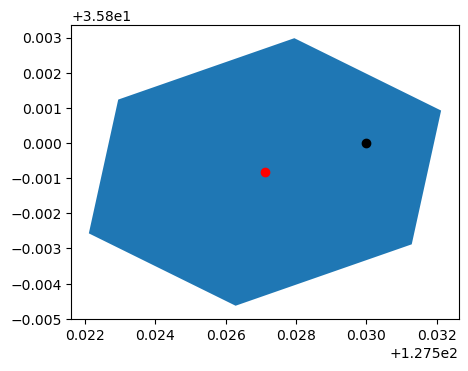

In [20]:
ax = gpd.GeoSeries(Polygon(h3_bnd)).plot(figsize=(5,5))
gpd.GeoSeries(Point(h3_point[1], h3_point[0])).plot(ax=ax, color='red')
gpd.GeoSeries(Point(point[1], point[0])).plot(ax=ax, color='black')
plt.show()

{'8830c42ebbfffff', '8830c42eb1fffff', '8830c42e95fffff', '8830c55b6dfffff', '8830c42e97fffff', '8830c42eb3fffff', '8830c42eb9fffff'}


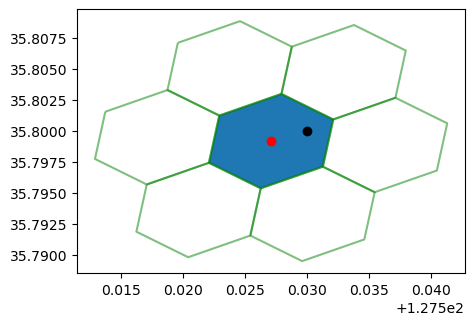

In [21]:
# to_polygon 함수 생성
def to_polygon(l):
    return Polygon(h3.h3_to_geo_boundary(l, geo_json=True))

# h3.k_ring: h3의 neighbor h3들 가져오기
neighbor_h3 = h3.k_ring(point_h3)
print(neighbor_h3)

ax = gpd.GeoSeries(Polygon(h3_bnd)).plot(figsize=(5,5))
for h in neighbor_h3:
    gpd.GeoSeries(to_polygon(h).boundary).plot(ax=ax, color='green', alpha=.5)
gpd.GeoSeries(Point(h3_point[1],h3_point[0])).plot(ax=ax, color='red')
gpd.GeoSeries(Point(point[1], point[0])).plot(ax=ax, color='black')
plt.show()

In [22]:
# h3.h3_indexes_are_neighbors: neighbor h3인지 판단하기
for h in neighbor_h3:
    cond = h3.h3_indexes_are_neighbors(point_h3, h)
    print(h,cond)

8830c42ebbfffff False
8830c42eb1fffff True
8830c42e95fffff True
8830c55b6dfffff True
8830c42e97fffff True
8830c42eb3fffff True
8830c42eb9fffff True


In [23]:
# h3.h3_distance: h3 index간의 거리(칸) 계산
point2 = earthquake_list.iloc[1][["위도","경도"]].values
point2_h3 = h3.geo_to_h3(point2[0], point2[1], res)
point2_h3_bnd = h3.h3_to_geo_boundary(point2_h3)

distance = h3.h3_distance(point_h3,point2_h3)
print(distance)

163


In [24]:
# h3.k_ring_distance: k내 거리에 있는 h3 index를 반환
k_h3 = h3.k_ring_distances(point_h3,1)
print(k_h3)

[{'8830c42ebbfffff'}, {'8830c42eb1fffff', '8830c42e95fffff', '8830c55b6dfffff', '8830c42e97fffff', '8830c42eb3fffff', '8830c42eb9fffff'}]


In [25]:
g = shapely.geometry.mapping(raw_gis["geometry"].iloc[0])
g['coordinates'] = [[[j[1],j[0]] for j in i] for i in g['coordinates']]  
hex_list = h3.polyfill(g,res=res)

print("*Resointion :",8)
print("*Number of hex :",len(hex_list))
g

*Resointion : 8
*Number of hex : 50


{'type': 'Polygon',
 'coordinates': [[[37.631183498319864, 126.97508533288955],
   [37.63048321400401, 126.97487894723284],
   [37.629805433065606, 126.97468142717287],
   [37.62967910126936, 126.9747264203075],
   [37.6290258463224, 126.97496550662665],
   [37.629084500792494, 126.97614454689263],
   [37.62908683081629, 126.97619200045405],
   [37.62929009823855, 126.97841861197482],
   [37.62928877034644, 126.97842202793541],
   [37.62921368887325, 126.97861493356935],
   [37.6290764124622, 126.97897125411825],
   [37.62902170031868, 126.97913897851873],
   [37.629005584981975, 126.97918824945597],
   [37.62889299662417, 126.9795273525088],
   [37.628551385645494, 126.97993197522236],
   [37.628455603384836, 126.97997189042883],
   [37.62828044565001, 126.98004601193168],
   [37.627933260464026, 126.98019012053109],
   [37.62787945710193, 126.9801523130341],
   [37.62745294530336, 126.97987728221864],
   [37.62677384571202, 126.97970120470643],
   [37.62645579363924, 126.979622031908

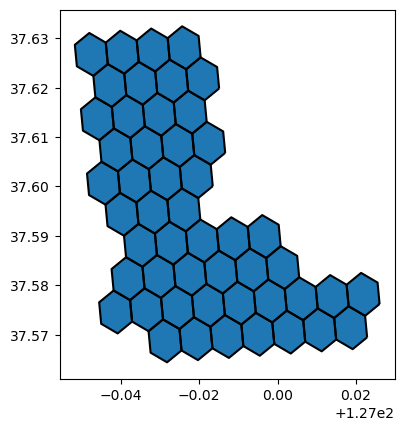

In [26]:
def to_polygon(l):
    return Polygon(h3.h3_to_geo_boundary(l, geo_json=True))

br_hex = pd.DataFrame(hex_list,columns=["hex_id"])
br_hex['geometry'] = br_hex["hex_id"].apply(lambda x : to_polygon(x))
br_hex = gpd.GeoDataFrame(br_hex, geometry='geometry', crs='epsg:4326')

ax = br_hex.plot()
br_hex.boundary.plot(ax=ax, color='black')
plt.show()

In [27]:
raw_gis_exploded=raw_gis.explode()
raw_gis_exploded

nyc_hex=gpd.GeoDataFrame()
for r in raw_gis_exploded.iterrows():
    name = r[1]["SIGUNGU_NM"]
    geom = r[1]["geometry"]
    g = shapely.geometry.mapping(geom)
    g['coordinates'] = [[[j[1],j[0]] for j in i] for i in g['coordinates']]  
    
    sub_df = gpd.GeoDataFrame({"SIGUNGU_NM":name,
                               "hex_id":list(h3.polyfill(g,res=6))})
    nyc_hex = nyc_hex.append(sub_df, ignore_index=True)
    print(name,":",len(sub_df))
print("*Total:", len(nyc_hex))

종로구 : 1
중구 : 1
용산구 : 1
성동구 : 1
광진구 : 0
동대문구 : 0
중랑구 : 1
성북구 : 1
강북구 : 1
도봉구 : 1
노원구 : 0
은평구 : 2
서대문구 : 0
마포구 : 1
양천구 : 0
강서구 : 1
구로구 : 1
금천구 : 1
영등포구 : 2
동작구 : 0
관악구 : 1
서초구 : 2
강남구 : 2
송파구 : 1
강동구 : 2
중구 : 0
서구 : 0
서구 : 0
서구 : 0
서구 : 1
동구 : 0
영도구 : 0
영도구 : 0
영도구 : 1
부산진구 : 1
동래구 : 1
남구 : 0
남구 : 0
남구 : 0
남구 : 0
남구 : 0
남구 : 0
남구 : 0
남구 : 1
북구 : 2
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 0
해운대구 : 1
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사하구 : 0
사

동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 0
동구 : 1
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 0
북구 : 6
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0
울주군 : 0

고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 0
고성군 : 23
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0
양양군 : 0

태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 4
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0
태안군 : 0


군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 1
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 17
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0
군산시 : 0

여수시 : 12
여수시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 0
순천시 : 37
나주시 : 22
광양시 : 0
광양시 : 0
광양시 : 2
광양시 : 0
광양시 : 0
광양시 : 16
담양군 : 19
곡성군 : 19
구례군 : 15
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고흥군 : 0
고

영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 0
영광군 : 20
장성군 : 20
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 0
완도군 : 

진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 1
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0
진도군 : 0


신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 2
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 1
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 2
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0
신안군 : 0


영덕군 : 0
영덕군 : 0
영덕군 : 0
영덕군 : 29
청도군 : 27
고령군 : 14
성주군 : 24
칠곡군 : 17
예천군 : 25
봉화군 : 46
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울진군 : 0
울

통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0
통영시 : 0


거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 0
거제시 : 16
양산시 : 18
창원시 의창구 : 8
창원시 성산구 : 0
창원시 성산구 : 4
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 1
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 : 0
창원시 마산합포구 

제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
제주시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 1
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0
서귀포시 : 0


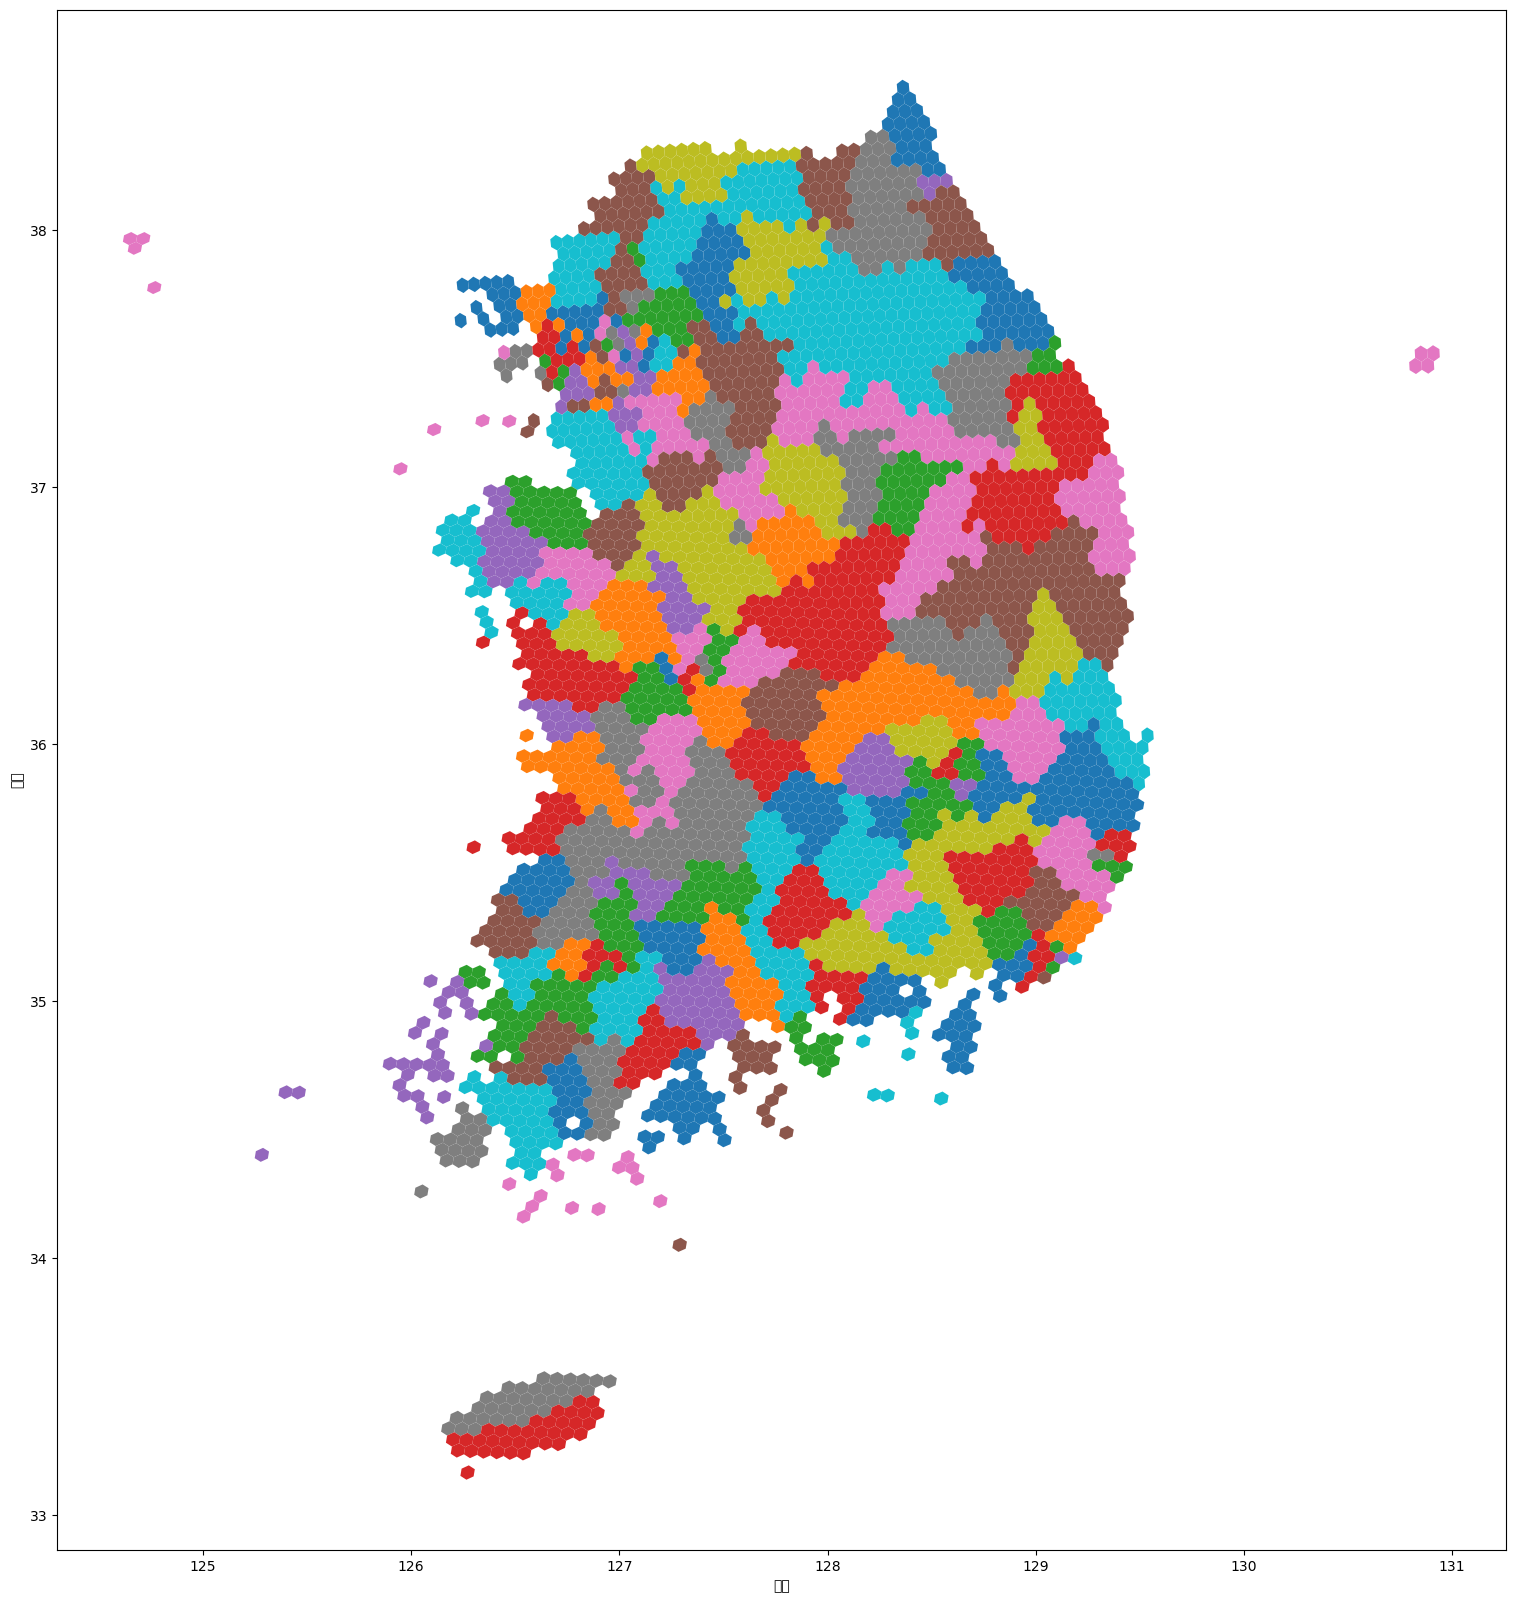

In [28]:
nyc_hex['geometry'] = nyc_hex["hex_id"].apply(lambda x : to_polygon(x))
nyc_hex = gpd.GeoDataFrame(nyc_hex, geometry='geometry', crs='epsg:4326')

nyc_hex.plot(column="SIGUNGU_NM", figsize=(20,20))
plt.xlabel('경도')
plt.ylabel('위도')
plt.show()